In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from sklearn.metrics import mean_absolute_error, r2_score

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
from torch_influence import BaseObjective, CGInfluenceModule, AutogradInfluenceModule

torch.manual_seed(666)
torch.set_default_dtype(torch.double)

In [2]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


class Forecaster(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [3]:
L2_WEIGHT = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TimeSeriesObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.mse_loss(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.mse_loss(outputs, batch[1])

In [36]:
airpassengers = sm.datasets.co2.load_pandas().data.dropna()

In [37]:
# manually introduce anomaly points
anomaly_time = ["1958-04-26", "1979-05-26", "1963-03-30", "1961-11-04", "1972-03-25"]
anomaly_value = [320., 330., 315.1, 320., 330.5]

In [38]:
contam_airpassengers = airpassengers.copy()
anomaly_idx = []
for i in range(len(anomaly_time)):
    contam_airpassengers.at[anomaly_time[i], 'co2'] = anomaly_value[i]
    anomaly_idx.append(np.where(contam_airpassengers.index == anomaly_time[i])[0][0])

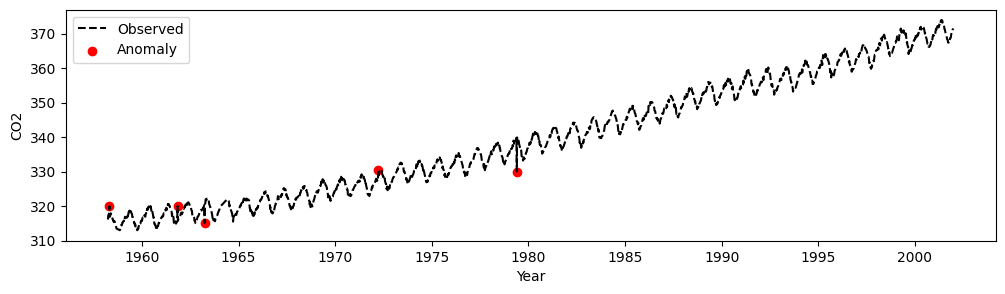

In [39]:
plt.figure(figsize=(12,3))
plt.plot(contam_airpassengers, color="k", linestyle="--", label="Observed")
plt.scatter(contam_airpassengers.index[anomaly_idx], anomaly_value, color='red', label='Anomaly')
plt.xlabel("Year")
plt.ylabel("CO2")
plt.legend()
# plt.savefig("../figures/contaminated_airpassengers.png", dpi=200)
plt.show()

In [40]:
contam_airpassengers = contam_airpassengers[:700].to_numpy()

##### isolated anomaly points

In [41]:
train_size = int(len(contam_airpassengers) * 0.8)
test_size = len(contam_airpassengers) - train_size
train, test = contam_airpassengers[:train_size], contam_airpassengers[train_size:]

In [42]:
lookback = 3
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([557, 3, 1]) torch.Size([557, 3, 1])
torch.Size([137, 3, 1]) torch.Size([137, 3, 1])


In [43]:
contam_model = Forecaster()
optimizer = optim.Adam(contam_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [44]:
n_epochs = 1500
for epoch in range(n_epochs):
    contam_model.train()
    for X_batch, y_batch in loader:
        y_pred = contam_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    contam_model.eval()
    with torch.no_grad():
        y_pred = contam_model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = contam_model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 317.3709, test RMSE 324.2641
Epoch 100: train RMSE 150.2336, test RMSE 157.0658
Epoch 200: train RMSE 35.5632, test RMSE 38.7434
Epoch 300: train RMSE 16.5994, test RMSE 18.2449
Epoch 400: train RMSE 4.9227, test RMSE 8.2154
Epoch 500: train RMSE 3.2463, test RMSE 6.4911
Epoch 600: train RMSE 3.1421, test RMSE 6.7126
Epoch 700: train RMSE 3.1077, test RMSE 6.5119
Epoch 800: train RMSE 3.0294, test RMSE 6.9338
Epoch 900: train RMSE 2.9690, test RMSE 6.2706
Epoch 1000: train RMSE 2.8644, test RMSE 6.4844
Epoch 1100: train RMSE 2.6092, test RMSE 5.8214
Epoch 1200: train RMSE 2.1018, test RMSE 4.8347
Epoch 1300: train RMSE 2.0752, test RMSE 4.1354
Epoch 1400: train RMSE 2.3320, test RMSE 3.7871


In [45]:
with torch.no_grad():
    # shift train predictions for plotting
    contam_train_plot = np.ones_like(contam_airpassengers) * np.nan
    y_pred = contam_model(X_train)
    y_pred = y_pred[:, -1, :]
    contam_train_plot[lookback:train_size] = contam_model(X_train)[:, -1, :]
    # shift test predictions for plotting
    contam_test_plot = np.ones_like(contam_airpassengers) * np.nan
    contam_test_plot[train_size+lookback:len(contam_airpassengers)] = contam_model(X_test)[:, -1, :]

In [46]:
contam_test_mae = mean_absolute_error(contam_model(X_test)[:,-1,:].detach().numpy().flatten(), y_test[:,-1,:].flatten())
contam_test_r2 = r2_score(contam_model(X_test)[:,-1,:].detach().numpy().flatten(), y_test[:,-1,:].flatten())

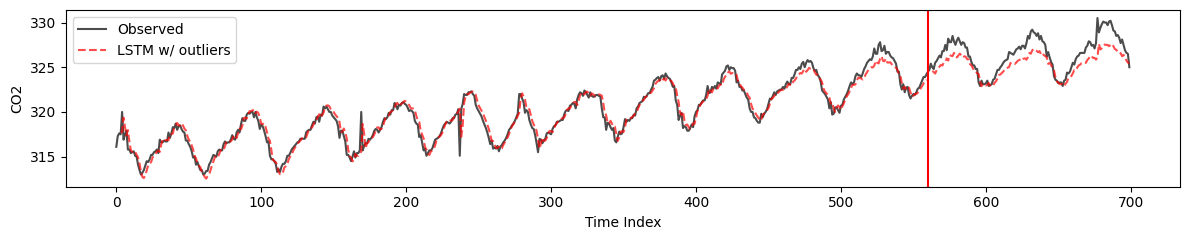

In [47]:
fig, ax = plt.subplots(1,1,figsize=(12,2.5))

ax.plot(contam_airpassengers, c='k', label="Observed", alpha=.7)
ax.plot(contam_train_plot, c='r', linestyle="--", alpha=.7)
ax.plot(contam_test_plot, c='r', linestyle="--", label="LSTM w/ outliers", alpha=.7)
ax.set_xlabel("Time Index")
ax.set_ylabel("CO2")
ax.axvline(x=train_size, c="r")
ax.legend()

plt.tight_layout()
plt.show()

In [48]:
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)

In [49]:
module = CGInfluenceModule(
    model=contam_model,
    objective=TimeSeriesObjective(),
    train_loader=data.DataLoader(train_set, batch_size=8),
    test_loader=data.DataLoader(test_set, batch_size=8),
    device=DEVICE,
    damp=0.001,
    atol=1e-8,
    maxiter=500,
)

In [50]:
test_losses = F.mse_loss(contam_model(X_test), y_test, reduction="none")
test_idxs = torch.argsort(test_losses.mean(1), dim=0, descending=True)[:5] # lower MSE better prediction
test_idxs = test_idxs.tolist()

In [51]:
saved_influences = []

all_train_idxs = list(range(X_train.shape[0]))
for test_idx in tqdm(test_idxs, desc="Computing Influences"):
    influences = module.influences(train_idxs=all_train_idxs, test_idxs=[test_idx[0]])
    saved_influences.append(influences)
    
train_influences = torch.stack(saved_influences).mean(0)

Computing Influences: 100%|██████████████████████| 5/5 [19:20<00:00, 232.19s/it]


In [52]:
most_helpful_points = torch.argsort(train_influences, descending=True)[:5]
most_harmful_points = torch.argsort(train_influences)[:5]

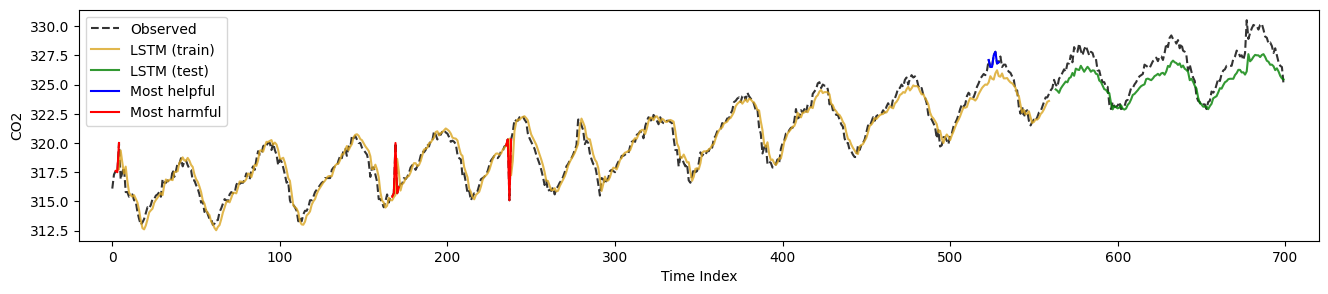

In [80]:
plt.figure(figsize=(16,3))
plt.plot(contam_airpassengers, c='k', linestyle="--", label="Observed", alpha=.8)
plt.plot(contam_train_plot, c='goldenrod', label="LSTM (train)", alpha=.8)
plt.plot(contam_test_plot, c='g', label="LSTM (test)", alpha=.8)

helpful_intervals = np.ones_like(contam_airpassengers) * np.nan
for _, point_idx in enumerate(most_helpful_points):
    interval_idxs = [point_idx, point_idx+1, point_idx+2]
    helpful_intervals[interval_idxs] = X_train[point_idx]

harmful_intervals = np.ones_like(contam_airpassengers) * np.nan
for _, point_idx in enumerate(most_harmful_points):
    interval_idxs = [point_idx, point_idx+1, point_idx+2]
    harmful_intervals[interval_idxs] = X_train[point_idx]

plt.plot(helpful_intervals, color='blue', label='Most helpful')
plt.plot(harmful_intervals, color='red', label='Most harmful')

plt.xlabel("Time Index")
plt.ylabel("CO2")
plt.legend()
plt.xlim(-20, 720)
plt.show()

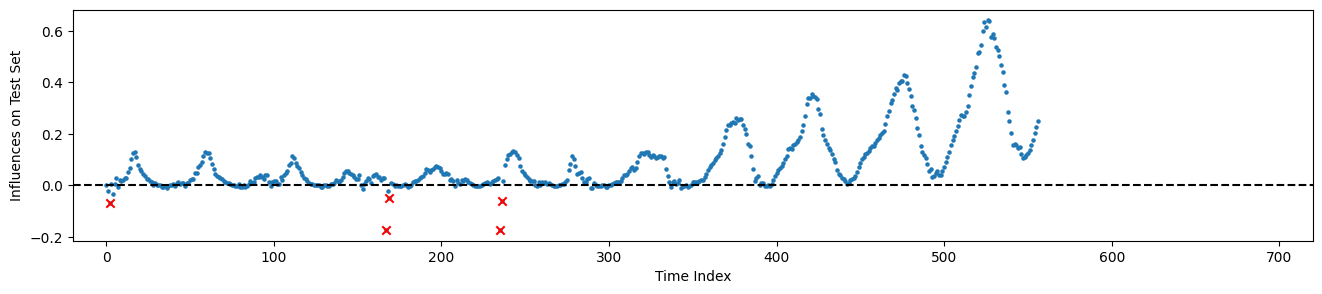

In [87]:
plt.figure(figsize=(16,3))
plt.scatter(np.arange(len(train_influences)), train_influences, s=5)
plt.scatter(most_harmful_points, train_influences[most_harmful_points], c="r", marker="x")
plt.axhline(y=0, c="k", linestyle="--")
plt.xlabel("Time Index")
plt.ylabel("Influences on Test Set")
plt.xlim(-20, 720)
plt.show()

In [112]:
cluster_centers = np.array([[train_influences.min()], [0.], [train_influences.max()]])
print(cluster_centers.T)

[[-0.17420108  0.          0.641624  ]]


In [113]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto", init=cluster_centers).fit(train_influences.reshape(-1,1))
clusters = kmeans.labels_
print(kmeans.cluster_centers_.T)

[[0.02255663 0.16617429 0.43689443]]


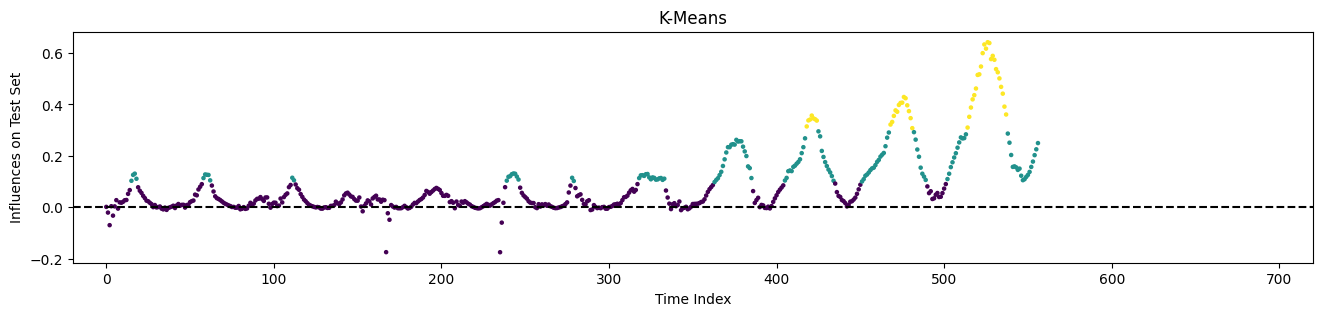

In [115]:
plt.figure(figsize=(16,3))
plt.scatter(np.arange(len(train_influences)), train_influences, s=5, c=clusters)
plt.axhline(y=0, c="k", linestyle="--")
plt.xlabel("Time Index")
plt.ylabel("Influences on Test Set")
plt.xlim(-20, 720)
plt.title("K-Means")
plt.show()

In [141]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest()
mask = (train_influences < 0) 
arg_mask = np.argwhere(train_influences < 0)
clf.fit(train_influences[mask].reshape(-1,1))
labels = clf.predict(train_influences[mask].reshape(-1,1))
labels = [-1 if label == -1 else 0 for label in labels]
clusters[arg_mask] = labels

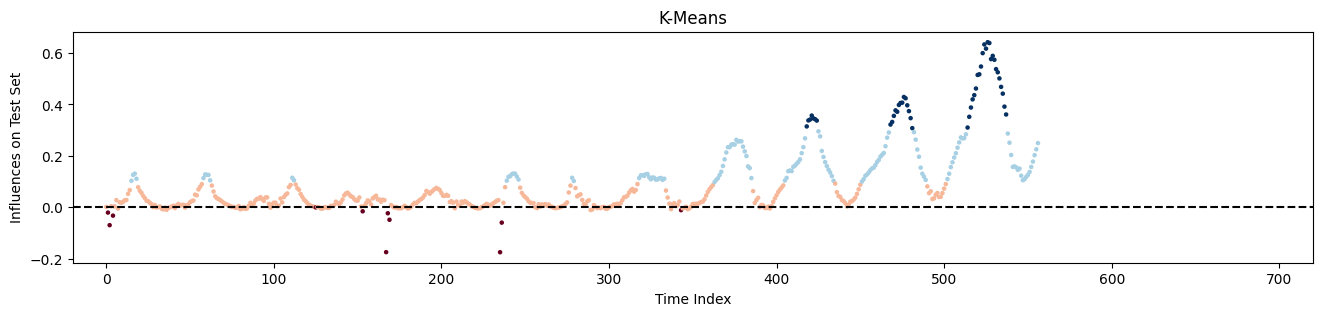

In [148]:
plt.figure(figsize=(16,3))
plt.scatter(np.arange(len(train_influences)), train_influences, s=5, c=clusters, cmap="RdBu")
plt.axhline(y=0, c="k", linestyle="--")
plt.xlabel("Time Index")
plt.ylabel("Influences on Test Set")
plt.xlim(-20, 720)
plt.title("K-Means")
plt.show()

##### contiguous anomaly points

In [57]:
airpassengers = sm.datasets.co2.load_pandas().data.dropna()

In [58]:
# manually introduce anomaly points
anomaly_time = ["1958-05-03", "1958-05-10", "1958-05-17", "1958-05-24", "1958-05-31"]
anomaly_value = [320., 321., 325., 322., 320.]

In [59]:
contam_airpassengers = airpassengers.copy()
anomaly_idx = []
for i in range(len(anomaly_time)):
    contam_airpassengers.at[anomaly_time[i], 'co2'] = anomaly_value[i]
    anomaly_idx.append(np.where(contam_airpassengers.index == anomaly_time[i])[0][0])

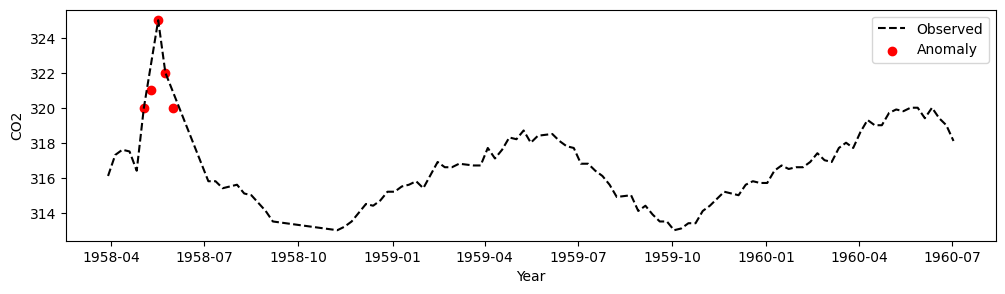

In [60]:
plt.figure(figsize=(12,3))
plt.plot(contam_airpassengers.iloc[:100], color="k", linestyle="--", label="Observed")
plt.scatter(contam_airpassengers.index[anomaly_idx], anomaly_value, color='red', label='Anomaly')
plt.xlabel("Year")
plt.ylabel("CO2")
plt.legend()
# plt.savefig("../figures/contiguous_anomaly_points.png", dpi=200)
plt.show()

In [61]:
airpassengers = airpassengers.co2.to_numpy()[:,None]
contam_airpassengers = contam_airpassengers.co2.to_numpy()[:,None]

In [62]:
airpassengers = airpassengers[:1000]
contam_airpassengers = contam_airpassengers[:1000]

In [35]:
train_size = int(len(contam_airpassengers) * 0.8)
test_size = len(contam_airpassengers) - train_size
train, test = contam_airpassengers[:train_size], contam_airpassengers[train_size:]

In [36]:
lookback = 3
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([797, 3, 1]) torch.Size([797, 3, 1])
torch.Size([197, 3, 1]) torch.Size([197, 3, 1])


In [37]:
contam_model = Forecaster()
optimizer = optim.Adam(contam_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [38]:
n_epochs = 2000
for epoch in range(n_epochs):
    contam_model.train()
    for X_batch, y_batch in loader:
        y_pred = contam_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    contam_model.eval()
    with torch.no_grad():
        y_pred = contam_model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = contam_model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 318.6426, test RMSE 328.8705
Epoch 100: train RMSE 74.5086, test RMSE 84.1296
Epoch 200: train RMSE 13.7494, test RMSE 17.1488
Epoch 300: train RMSE 6.8173, test RMSE 11.8127
Epoch 400: train RMSE 4.3937, test RMSE 10.3823
Epoch 500: train RMSE 3.8472, test RMSE 8.1698
Epoch 600: train RMSE 3.1924, test RMSE 7.7616
Epoch 700: train RMSE 2.8895, test RMSE 6.0736
Epoch 800: train RMSE 2.7464, test RMSE 6.1102
Epoch 900: train RMSE 2.2828, test RMSE 4.6542
Epoch 1000: train RMSE 2.3481, test RMSE 4.7912
Epoch 1100: train RMSE 2.0500, test RMSE 4.8410
Epoch 1200: train RMSE 1.6352, test RMSE 3.6541
Epoch 1300: train RMSE 1.6653, test RMSE 2.8910
Epoch 1400: train RMSE 1.2295, test RMSE 2.0586
Epoch 1500: train RMSE 1.0337, test RMSE 2.3198
Epoch 1600: train RMSE 0.8475, test RMSE 1.6682
Epoch 1700: train RMSE 1.2251, test RMSE 2.1540
Epoch 1800: train RMSE 0.7515, test RMSE 0.8297
Epoch 1900: train RMSE 0.6570, test RMSE 1.0121


In [39]:
with torch.no_grad():
    # shift train predictions for plotting
    contam_train_plot = np.ones_like(contam_airpassengers) * np.nan
    y_pred = contam_model(X_train)
    y_pred = y_pred[:, -1, :]
    contam_train_plot[lookback:train_size] = contam_model(X_train)[:, -1, :]
    # shift test predictions for plotting
    contam_test_plot = np.ones_like(contam_airpassengers) * np.nan
    contam_test_plot[train_size+lookback:len(contam_airpassengers)] = contam_model(X_test)[:, -1, :]

In [40]:
contam_test_mae = mean_absolute_error(contam_model(X_test)[:,-1,:].detach().numpy().flatten(), y_test[:,-1,:].flatten())
contam_test_r2 = r2_score(contam_model(X_test)[:,-1,:].detach().numpy().flatten(), y_test[:,-1,:].flatten())

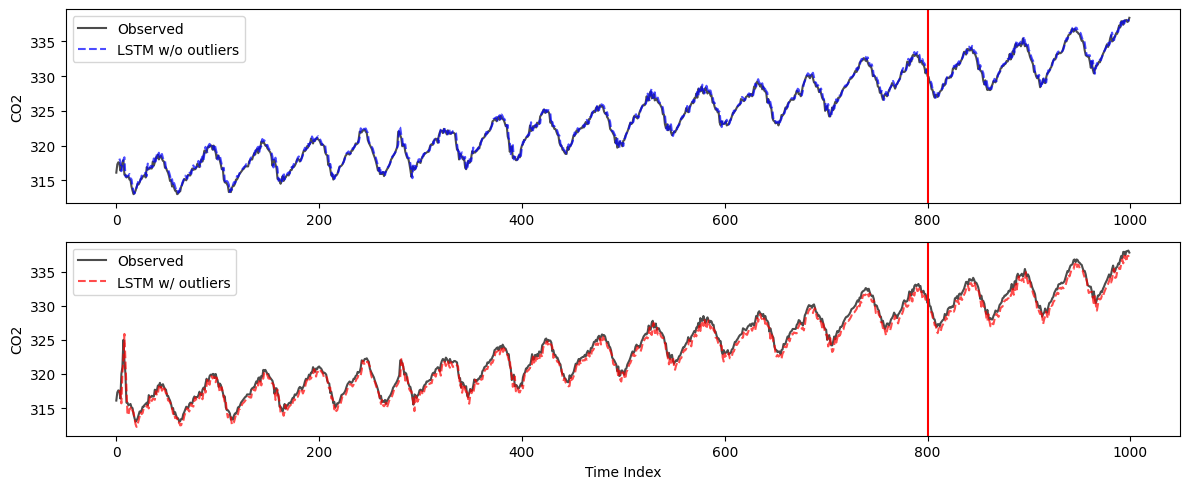

In [44]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,5))

ax1.plot(airpassengers, c='k', label="Observed", alpha=.7)
ax1.plot(train_plot, c='b', linestyle="--", alpha=.7)
ax1.plot(test_plot, c='b', linestyle="--", label="LSTM w/o outliers", alpha=.7)
ax1.axvline(x=train_size, c="r")
ax1.set_ylabel("CO2")
ax1.legend()
# ax1.set_title(f"Test R2: {test_r2:.4f}")

ax2.plot(contam_airpassengers, c='k', label="Observed", alpha=.7)
ax2.plot(contam_train_plot, c='r', linestyle="--", alpha=.7)
ax2.plot(contam_test_plot, c='r', linestyle="--", label="LSTM w/ outliers", alpha=.7)
ax2.set_xlabel("Time Index")
ax2.set_ylabel("CO2")
ax2.axvline(x=train_size, c="r")
ax2.legend()
# ax2.set_title(f"Test R2: {contam_test_r2:.4f}")

plt.tight_layout()
# plt.savefig("../figures/airpassengers_predictions_contiguous.png", dpi=200)
plt.show()

In [45]:
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)

In [46]:
module = CGInfluenceModule(
    model=contam_model,
    objective=TimeSeriesObjective(),
    train_loader=data.DataLoader(train_set, batch_size=8),
    test_loader=data.DataLoader(test_set, batch_size=8),
    device=DEVICE,
    damp=0.001,
    atol=1e-8,
    maxiter=500,
)

In [47]:
test_losses = F.mse_loss(contam_model(X_test), y_test, reduction="none")
test_idxs = torch.argsort(test_losses.mean(1), dim=0, descending=True)[:5] # lower MSE better prediction
test_idxs = test_idxs.tolist()

In [48]:
saved_influences = []

all_train_idxs = list(range(X_train.shape[0]))
for test_idx in tqdm(test_idxs, desc="Computing Influences"):
    influences = module.influences(train_idxs=all_train_idxs, test_idxs=[test_idx[0]])
    saved_influences.append(influences)
    
train_influences = torch.stack(saved_influences).mean(0)

Computing Influences: 100%|██████████████████████| 5/5 [27:42<00:00, 332.58s/it]


In [53]:
most_helpful_points = torch.argsort(train_influences, descending=True)[:5]
most_harmful_points = torch.argsort(train_influences)[:5]

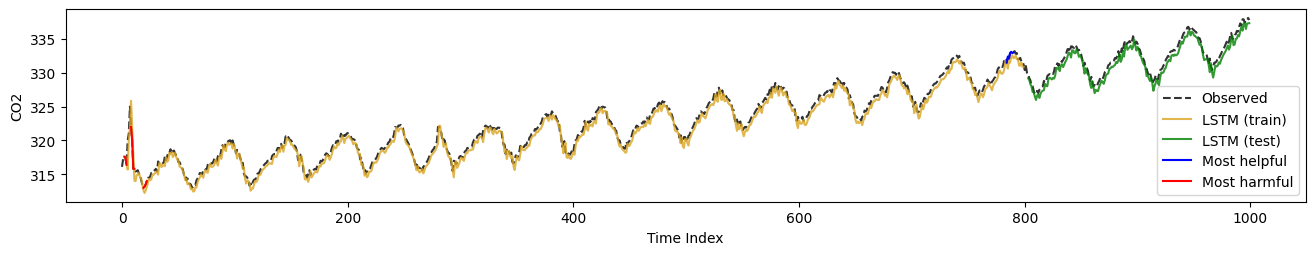

In [55]:
plt.figure(figsize=(16,2.5))
plt.plot(contam_airpassengers, c='k', linestyle="--", label="Observed", alpha=.8)
plt.plot(contam_train_plot, c='goldenrod', label="LSTM (train)", alpha=.8)
plt.plot(contam_test_plot, c='g', label="LSTM (test)", alpha=.8)

helpful_intervals = np.ones_like(contam_airpassengers) * np.nan
for _, point_idx in enumerate(most_helpful_points):
    interval_idxs = [point_idx, point_idx+1, point_idx+2]
    helpful_intervals[interval_idxs] = X_train[point_idx]

harmful_intervals = np.ones_like(contam_airpassengers) * np.nan
for _, point_idx in enumerate(most_harmful_points):
    interval_idxs = [point_idx, point_idx+1, point_idx+2]
    harmful_intervals[interval_idxs] = X_train[point_idx]

plt.plot(helpful_intervals, color='blue', label='Most helpful')
plt.plot(harmful_intervals, color='red', label='Most harmful')

plt.xlabel("Time Index")
plt.ylabel("CO2")
plt.legend()
# plt.savefig("../figures/airpassengers_identified_anomalies_contiguous.png", dpi=200)
plt.show()